In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost
from sklearn.metrics import *
from imblearn.under_sampling import *
from imblearn.over_sampling import *
from imblearn.combine import *
from sklearn.model_selection import train_test_split


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 30000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 모델링

In [2]:
df_pre = pd.read_csv('data/df_pre.csv')
print(np.shape(df_pre))
df_pre.tail()

(26729, 23)


,Unnamed: 0,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Season,Quarter,Group,Size
26724,26724,18631,0,14983,4,Partner,0,1,2,640,111,2,30,2,1,80,2,4,19,1,1,8,5
26725,26725,26055,0,22209,4,SCRP,0,3,24,640,104,2,90,2,1,80,3,0,27,3,0,8,5
26726,26726,16731,1,13463,0,NaN,1,2,30,1022,353,22,1460,20,1,147,2,2,17,1,0,12,9
26727,26727,7450,0,5074,4,Partner,0,1,29,640,5,0,28,2,1,80,1,3,6,1,1,8,5
26728,26728,20751,0,16611,4,SCRP,0,1,5,640,111,2,365,2,1,80,2,6,21,2,2,8,5


In [3]:
del df_pre['Unnamed: 0']

In [4]:
print(np.shape(df_pre))
df_pre.tail()

(26729, 22)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Color_pre,DayuponOutcome,AboutAge,BreedMix,Breed_pre,Year,Month,YearMonth,Season,Quarter,Group,Size
26724,18631,0,14983,4,Partner,0,1,2,640,111,2,30,2,1,80,2,4,19,1,1,8,5
26725,26055,0,22209,4,SCRP,0,3,24,640,104,2,90,2,1,80,3,0,27,3,0,8,5
26726,16731,1,13463,0,NaN,1,2,30,1022,353,22,1460,20,1,147,2,2,17,1,0,12,9
26727,7450,0,5074,4,Partner,0,1,29,640,5,0,28,2,1,80,1,3,6,1,1,8,5
26728,20751,0,16611,4,SCRP,0,1,5,640,111,2,365,2,1,80,2,6,21,2,2,8,5


# Random Forest (전체 feature importances) 

In [85]:
columns = ['Name', 'DateTime','AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']
df_x = df_pre[columns]
df_y = df_pre.iloc[:, [3]]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.1, random_state=0, shuffle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)

print('train score: {}'.format(rf.score(X_train, y_train)))
print('test score: {}'.format(rf.score(X_test, y_test)))
print('log loss: {}'.format(log_loss(y_test, rf_probs)))
print()

train score: 0.9999584303292318
test score: 0.6105499438832772
log loss: 1.2224696657297092



Feature ranking:
1. feature 1 (0.307602)
2. feature 4 (0.158759)
3. feature 6 (0.158373)
4. feature 3 (0.151604)
5. feature 5 (0.145319)
6. feature 0 (0.052369)
7. feature 2 (0.025976)


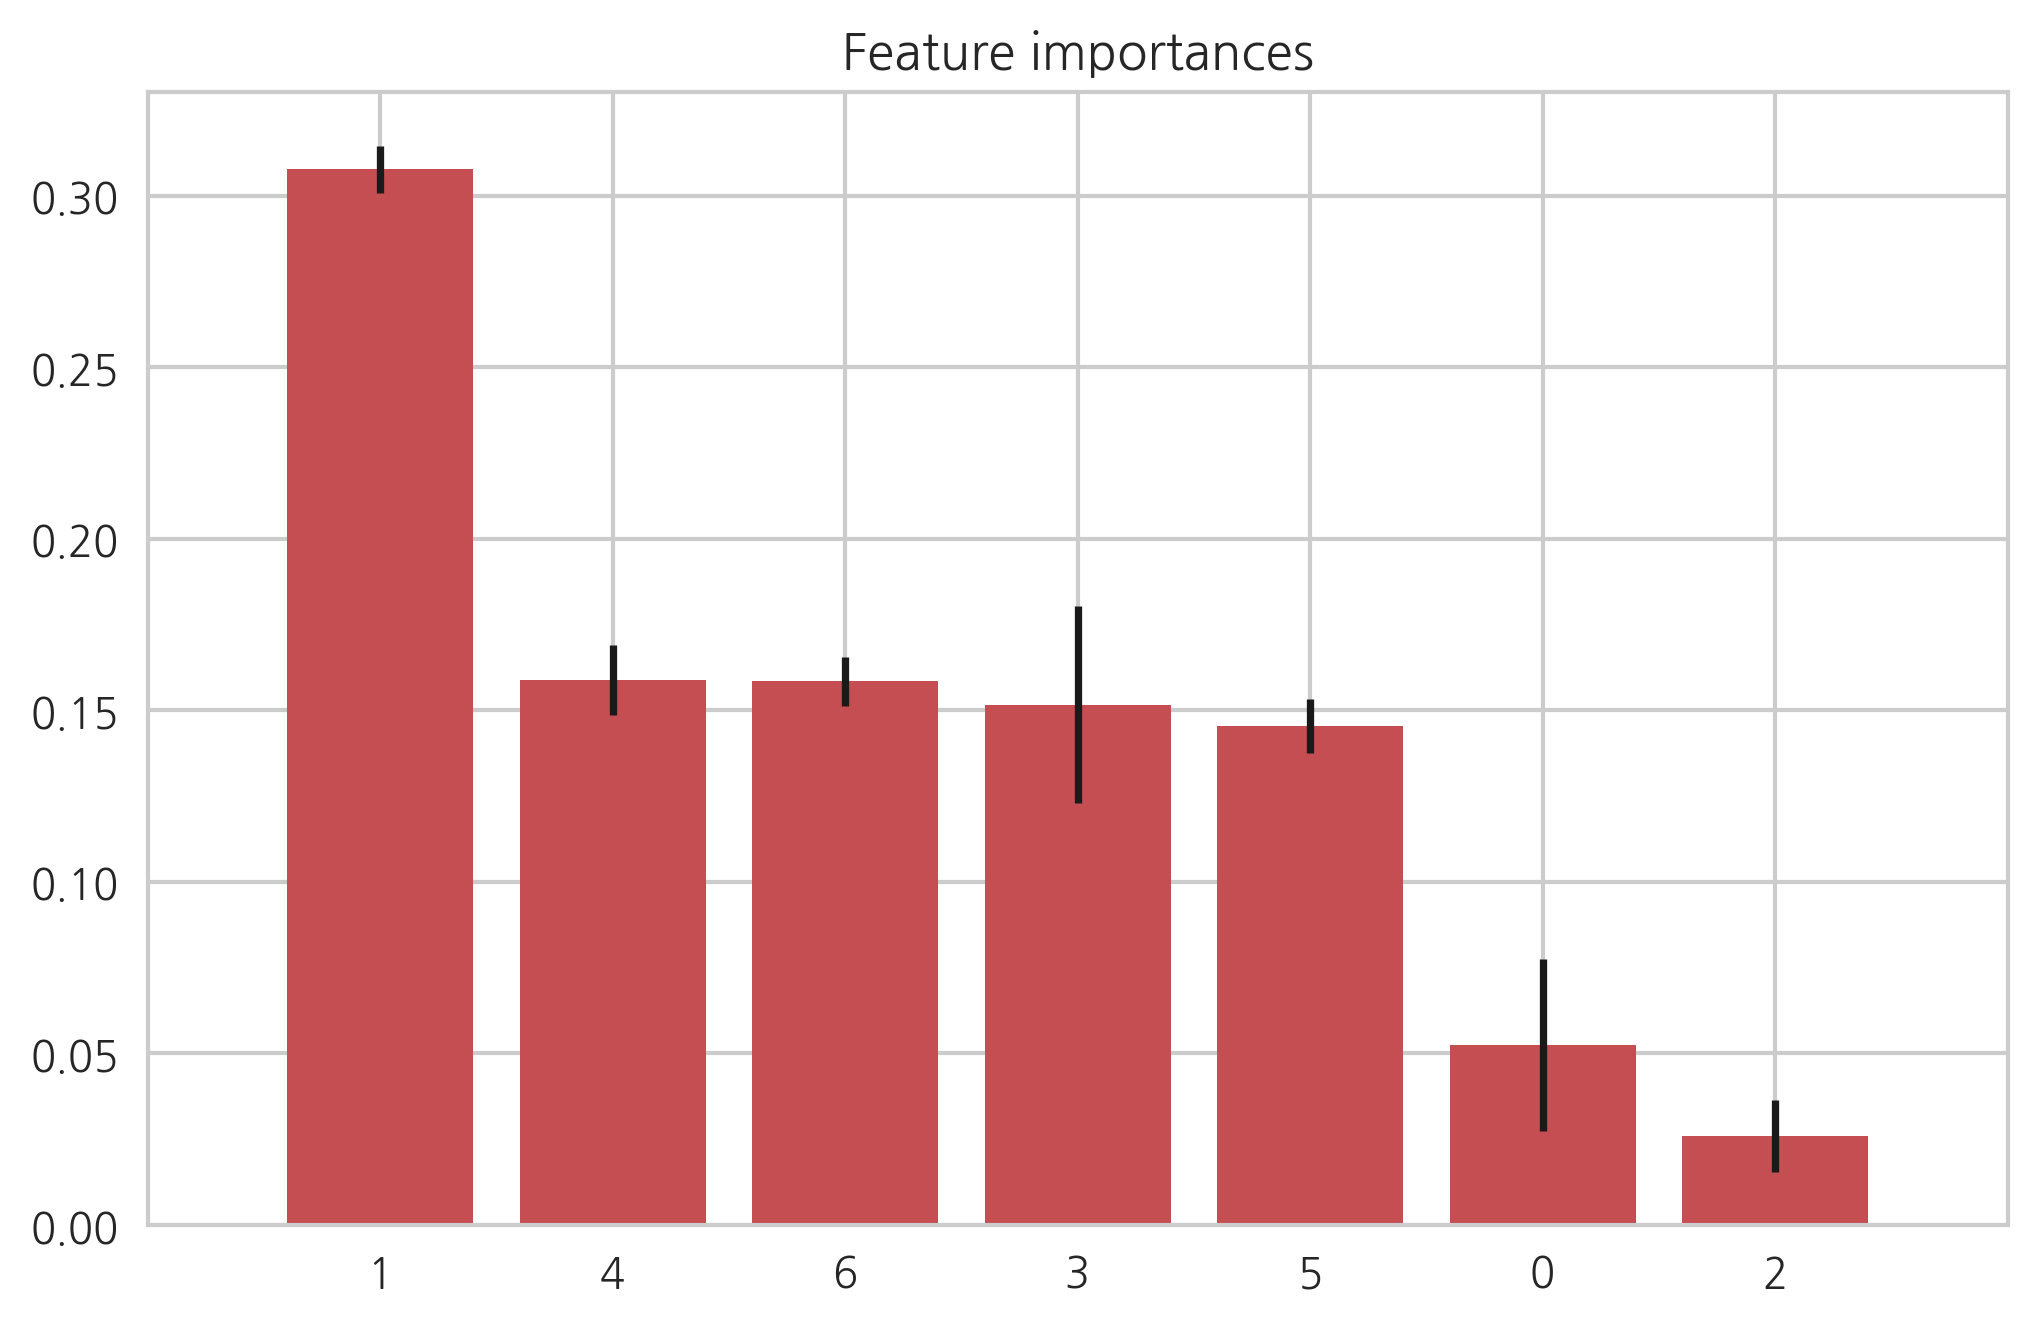

In [86]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(df_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])
plt.show()

In [87]:
df_x.iloc[0, [1,4,6,3,5,0,2]]

DateTime          3361
AgeuponOutcome       5
Color              130
SexuponOutcome       2
Breed             1221
Name                 1
AnimalType           1
Name: 0, dtype: int64

# Random Forest (전체 feature importances) _전처리만

In [71]:
columns = ['YearMonth', 'Color', 'Breed', 'Name', 'AnimalType', 'SexuponOutcome', 'DayuponOutcome','BreedMix']
df_x = df_pre.iloc[:, [1,2,5,6,7,9,10,11,13,14,16,17]]
df_y = df_pre.iloc[:, [3]]

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(df_x, df_y)

print('log loss: {}'.format(np.mean(-cross_val_score(rf, df_x, df_y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 1.1527189704328142



Feature ranking:
1. feature 1 (0.185199)
2. feature 3 (0.145010)
3. feature 7 (0.130446)
4. feature 5 (0.104535)
5. feature 9 (0.100136)
6. feature 11 (0.071149)
7. feature 10 (0.065144)
8. feature 4 (0.060294)
9. feature 6 (0.056315)
10. feature 0 (0.051367)
11. feature 2 (0.021712)
12. feature 8 (0.008695)


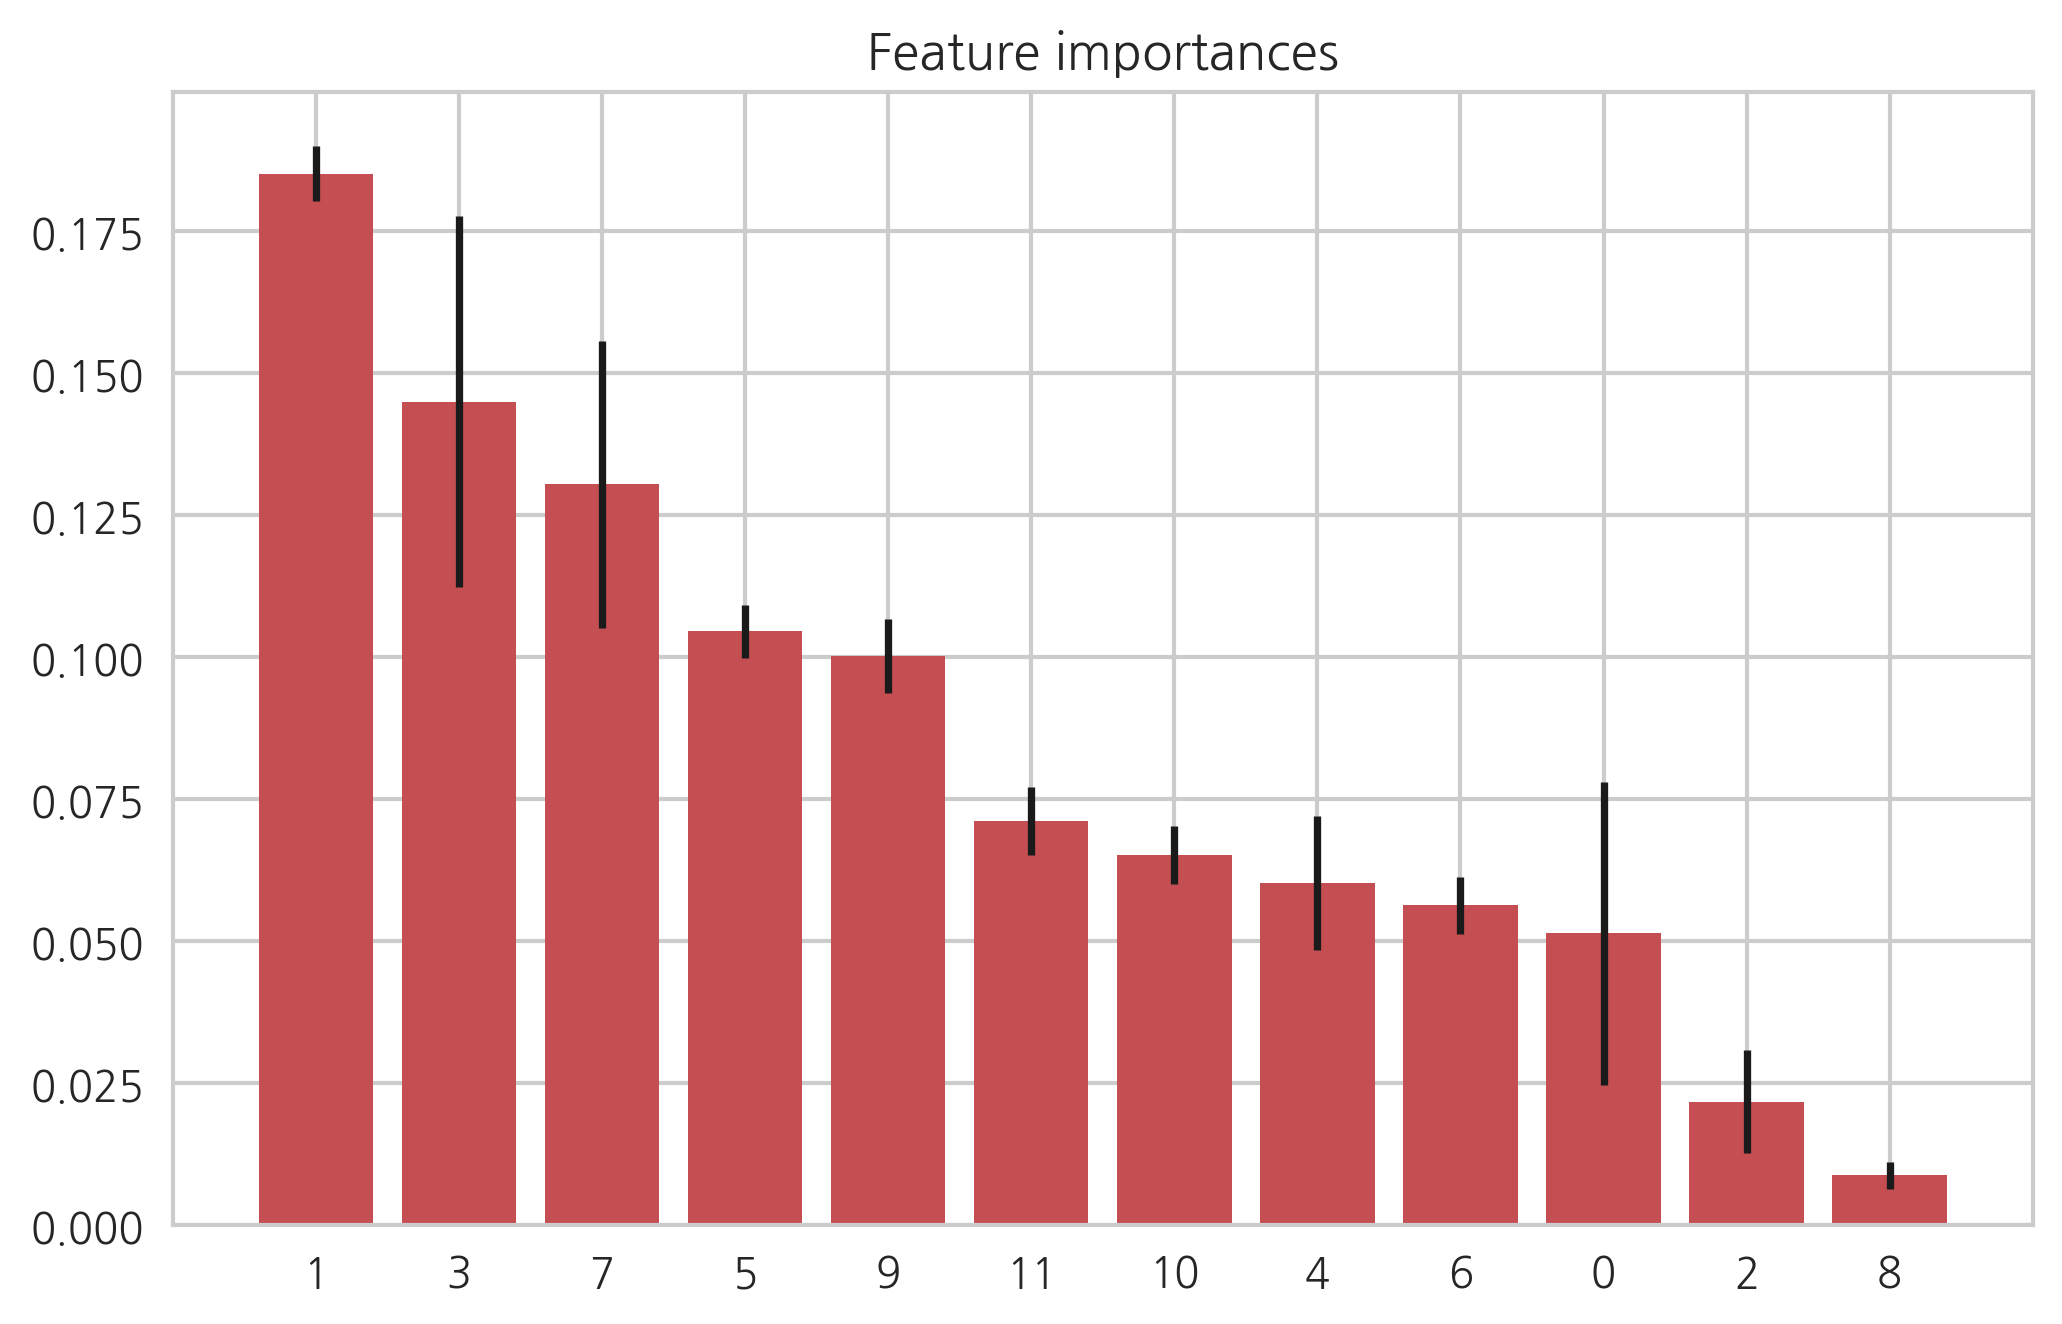

In [72]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

importances = rf.feature_importances_

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(df_x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])
plt.show()

In [74]:
df_x.iloc[0, [1,3,7,5,9,11,10,4,6,0,2,8]]

DateTime          3361
SexuponOutcome       2
DayuponOutcome     365
Color              130
Breed_pre          181
YearMonth            4
Month                1
AgeuponOutcome       5
Color_pre            2
Name                 1
AnimalType           1
BreedMix             1
Name: 0, dtype: int64

# TomekLinks

In [33]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = TomekLinks(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=215, max_depth=6, learning_rate=0.036766246873674434)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.7595512370575527



In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[464   0   0  61  15]
 [  1   1   0   0   3]
 [ 10   0  18  13  29]
 [ 99   0   2 130  21]
 [127   0   3  30 310]]
             precision    recall  f1-score   support

          0       0.66      0.86      0.75       540
          1       1.00      0.20      0.33         5
          2       0.78      0.26      0.39        70
          3       0.56      0.52      0.53       252
          4       0.82      0.66      0.73       470

avg / total       0.71      0.69      0.68      1337



In [39]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color','DayuponOutcome','Breed','Name','DateTime' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = TomekLinks(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.10000000000000001)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.7196294950335321



In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[472   0   0  45  23]
 [  0   3   0   0   2]
 [ 10   1  22  10  27]
 [ 96   0   2 139  15]
 [103   0   4  35 328]]
             precision    recall  f1-score   support

          0       0.69      0.87      0.77       540
          1       0.75      0.60      0.67         5
          2       0.79      0.31      0.45        70
          3       0.61      0.55      0.58       252
          4       0.83      0.70      0.76       470

avg / total       0.73      0.72      0.71      1337



# RandomUnderSampler

In [77]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = RandomUnderSampler(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=100)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 1.2461879265807112



# CondensedNearestNeighbour

In [78]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = CondensedNearestNeighbour(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=100)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 1.2469488188696434



# OneSidedSelection

In [13]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = OneSidedSelection(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=100)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

/home/dockeruser/anaconda3/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  idx_maj_extracted = np.delete(idx_maj, idx_maj_sample, axis=0)
/home/dockeruser/anaconda3/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  idx_maj_extracted = np.delete(idx_maj, idx_maj_sample, axis=0)


log loss: 0.7708216463923311



In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[464   0   0  63  13]
 [  1   0   0   0   4]
 [ 12   0   8  16  34]
 [109   0   1 114  28]
 [135   0   1  30 304]]
             precision    recall  f1-score   support

          0       0.64      0.86      0.74       540
          1       0.00      0.00      0.00         5
          2       0.80      0.11      0.20        70
          3       0.51      0.45      0.48       252
          4       0.79      0.65      0.71       470

avg / total       0.68      0.67      0.65      1337



# NeighbourhoodCleaningRule

In [15]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = NeighbourhoodCleaningRule(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=100)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.4389084372049467



In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[502   0   0  29   9]
 [  1   0   0   0   4]
 [ 18   0   9  10  33]
 [142   0   2  82  26]
 [151   0   3  23 293]]
             precision    recall  f1-score   support

          0       0.62      0.93      0.74       540
          1       0.00      0.00      0.00         5
          2       0.64      0.13      0.21        70
          3       0.57      0.33      0.41       252
          4       0.80      0.62      0.70       470

avg / total       0.67      0.66      0.64      1337



# SMOTETomek

In [84]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = SMOTETomek(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=100)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.8366516241392828



In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[391   2   3 136   8]
 [  1   1   0   0   3]
 [  4   0  23  17  26]
 [ 57   0   9 171  15]
 [ 94  25  29  76 246]]
             precision    recall  f1-score   support

          0       0.71      0.72      0.72       540
          1       0.04      0.20      0.06         5
          2       0.36      0.33      0.34        70
          3       0.43      0.68      0.52       252
          4       0.83      0.52      0.64       470

avg / total       0.68      0.62      0.63      1337



# SMOTEENN

In [17]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = SMOTEENN(random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=200, max_depth=5)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.5506940500193728



In [18]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[306  12  17 200   5]
 [  0   3   0   0   2]
 [  0   1  34  18  17]
 [ 16   0  28 199   9]
 [ 52  54  66 111 187]]
             precision    recall  f1-score   support

          0       0.82      0.57      0.67       540
          1       0.04      0.60      0.08         5
          2       0.23      0.49      0.32        70
          3       0.38      0.79      0.51       252
          4       0.85      0.40      0.54       470

avg / total       0.71      0.55      0.57      1337



# ADASYN

In [21]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=100)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.6772398630818803



In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[466   0   0  60  14]
 [  1   0   0   0   4]
 [ 11   0  12  14  33]
 [106   0   2 115  29]
 [128   0   1  34 307]]
             precision    recall  f1-score   support

          0       0.65      0.86      0.74       540
          1       0.00      0.00      0.00         5
          2       0.80      0.17      0.28        70
          3       0.52      0.46      0.48       252
          4       0.79      0.65      0.72       470

avg / total       0.68      0.67      0.66      1337



In [28]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color','DayuponOutcome','Breed','Name','DateTime' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=215, max_depth=5)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.6064760374927416



In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[484   0   0  47   9]
 [  1   0   0   0   4]
 [  9   0  22  14  25]
 [ 93   0   2 140  17]
 [105   0   4  34 327]]
             precision    recall  f1-score   support

          0       0.70      0.90      0.79       540
          1       0.00      0.00      0.00         5
          2       0.79      0.31      0.45        70
          3       0.60      0.56      0.57       252
          4       0.86      0.70      0.77       470

avg / total       0.74      0.73      0.72      1337



# TEST!!!!!!!!!

In [63]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.1, random_state=0, shuffle=True)
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(X_train, y_train)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=215)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, X_test, y_test, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.8776568043318861



In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[472   0   0  53  15]
 [  1   0   0   0   4]
 [  9   0  21  12  28]
 [ 95   0   3 134  20]
 [115   0   7  31 317]]
             precision    recall  f1-score   support

          0       0.68      0.87      0.77       540
          1       0.00      0.00      0.00         5
          2       0.68      0.30      0.42        70
          3       0.58      0.53      0.56       252
          4       0.83      0.67      0.74       470

avg / total       0.71      0.71      0.70      1337



In [56]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)

model_xgb_imb = xgboost.XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.3)
model_xgb_imb.fit(df_final, y)

print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
print()

log loss: 0.6021628533230596



In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_imb_x, df_imb_y, test_size = 0.05, random_state=0, shuffle=True)
print(confusion_matrix(y_test, model_xgb_imb.predict(X_test)))
print(classification_report(y_test, model_xgb_imb.predict(X_test)))

[[471   0   0  50  19]
 [  1   0   0   0   4]
 [  9   0  20  11  30]
 [ 97   0   3 133  19]
 [110   0   6  33 321]]
             precision    recall  f1-score   support

          0       0.68      0.87      0.77       540
          1       0.00      0.00      0.00         5
          2       0.69      0.29      0.40        70
          3       0.59      0.53      0.56       252
          4       0.82      0.68      0.74       470

avg / total       0.71      0.71      0.70      1337



In [42]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)

from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)
for i in [250,270,290,310,330,350]:
    model_xgb_imb = xgboost.XGBClassifier(n_estimators=i)
    model_xgb_imb.fit(df_final, y)
    
    print('estimators :', i)
    print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
    print()

estimators : 250
log loss: 0.6212852980572002

estimators : 270
log loss: 0.6181643268350706

estimators : 290
log loss: 0.6160845616121773

estimators : 310
log loss: 0.6133815795451955

estimators : 330
log loss: 0.6116997782947657

estimators : 350
log loss: 0.6098442383532491



In [53]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)


from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)
for i in [2,3,4,5,6,7,8]:
    model_xgb_imb = xgboost.XGBClassifier(n_estimators=300, max_depth=i, learning_rate=0.25)
    model_xgb_imb.fit(df_final, y)
    
    print('max_depth :', i)
    print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
    print()

max_depth : 2
log loss: 0.6085766881011869

max_depth : 3
log loss: 0.6025888330181968

max_depth : 4
log loss: 0.6090723003236898

max_depth : 5


KeyboardInterrupt: 

In [55]:
df_imb = pd.read_csv('data/df_pre.csv')
del df_imb['Unnamed: 0']

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True)


from imblearn.combine import *
columns=['SexuponOutcome','Color_pre','DayuponOutcome','Breed_pre','Name','YearMonth', 'Month' ,'AnimalType','BreedMix']

df_imb_x = df_imb[columns]
df_imb_y = df_imb.iloc[:, [3]]
X, y = ADASYN(ratio='minority', random_state=0).fit_sample(df_imb_x, df_imb_y)
df_final = pd.DataFrame(X, columns=columns)
for i in [0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08]:
    model_xgb_imb = xgboost.XGBClassifier(n_estimators=300, max_depth=3, learning_rate=i)
    model_xgb_imb.fit(df_final, y)
    
    print('lr :', i)
    print('log loss: {}'.format(np.mean(-cross_val_score(model_xgb_imb, df_final, y, scoring="neg_log_loss", cv=cv))))
    print()

lr : 0.05
log loss: 0.650968755142683

lr : 0.055
log loss: 0.6440485680264121

lr : 0.06
log loss: 0.6390126841200098

lr : 0.065
log loss: 0.6346055067006182

lr : 0.07
log loss: 0.6301904185683938

lr : 0.075


KeyboardInterrupt: 